In [40]:
import sys
sys.path.append('../..')

In [41]:
import torch

if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

In [42]:
from src.tool.registry import DATASET_REGISTRY

dataset = DATASET_REGISTRY['Footprint2Pressure_SensorStack_Blend'](
    device = device,
    footprint_wrap_folder = '../../data/processed/footprint-wrap/',
    pedar_dynamic_path = '../../data/processed/pedar_dynamic.pkl',
    l_mask_path = '../../data/processed/left_foot_mask.png',
    sense_range = 600,
    stack_range = 50,
    img_size = 10,
)

## Naive regression $f = 1 - x$

In [14]:
num = 200.0
x = torch.arange(num, device=device) / num
y = torch.arange(num, device=device).flip(0) / num
x, y

(tensor([0.0000, 0.0050, 0.0100, 0.0150, 0.0200, 0.0250, 0.0300, 0.0350, 0.0400,
         0.0450, 0.0500, 0.0550, 0.0600, 0.0650, 0.0700, 0.0750, 0.0800, 0.0850,
         0.0900, 0.0950, 0.1000, 0.1050, 0.1100, 0.1150, 0.1200, 0.1250, 0.1300,
         0.1350, 0.1400, 0.1450, 0.1500, 0.1550, 0.1600, 0.1650, 0.1700, 0.1750,
         0.1800, 0.1850, 0.1900, 0.1950, 0.2000, 0.2050, 0.2100, 0.2150, 0.2200,
         0.2250, 0.2300, 0.2350, 0.2400, 0.2450, 0.2500, 0.2550, 0.2600, 0.2650,
         0.2700, 0.2750, 0.2800, 0.2850, 0.2900, 0.2950, 0.3000, 0.3050, 0.3100,
         0.3150, 0.3200, 0.3250, 0.3300, 0.3350, 0.3400, 0.3450, 0.3500, 0.3550,
         0.3600, 0.3650, 0.3700, 0.3750, 0.3800, 0.3850, 0.3900, 0.3950, 0.4000,
         0.4050, 0.4100, 0.4150, 0.4200, 0.4250, 0.4300, 0.4350, 0.4400, 0.4450,
         0.4500, 0.4550, 0.4600, 0.4650, 0.4700, 0.4750, 0.4800, 0.4850, 0.4900,
         0.4950, 0.5000, 0.5050, 0.5100, 0.5150, 0.5200, 0.5250, 0.5300, 0.5350,
         0.5400, 0.5450, 0.5

In [15]:
y.std()

tensor(0.2894, device='mps:0')

In [16]:
from torch import nn

hidden = 5000

model = nn.Sequential(
    nn.Linear(1, hidden),
    nn.ReLU(),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 1),
    
).to(device)

In [17]:
# import numpy as np
# from tqdm.auto import tqdm

# loss_ls = []
# loss_fn = nn.MSELoss()

# for epoch in (pdar := tqdm(range(100 * 5))):
#     index = np.random.randint(num)
#     y_pred = model(x[index].unsqueeze(-1))
#     loss = loss_fn(y[index].unsqueeze(-1), y_pred)
#     loss_ls.append(loss.item())
#     pdar.set_description(f'loss {loss.item():.4f} std {y_pred.std().item():.4f}')

#     loss.backward()
#     with torch.no_grad():
#         for param in model.parameters():
#             param -= 0.0001 * param.grad
#             param.grad.zero_()

In [18]:
import numpy as np
from tqdm.auto import tqdm

loss_ls = []
loss_fn = nn.MSELoss()

for epoch in (pdar := tqdm(range(100 * 5))):
    y_pred = model(x.unsqueeze(-1))
    loss = loss_fn(y.unsqueeze(-1), y_pred)
    loss_ls.append(loss.item())
    pdar.set_description(f'loss {loss.item():.4f} std {y_pred.std().item():.4f}')

    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= 0.001 * param.grad
            param.grad.zero_()

  0%|          | 0/500 [00:00<?, ?it/s]

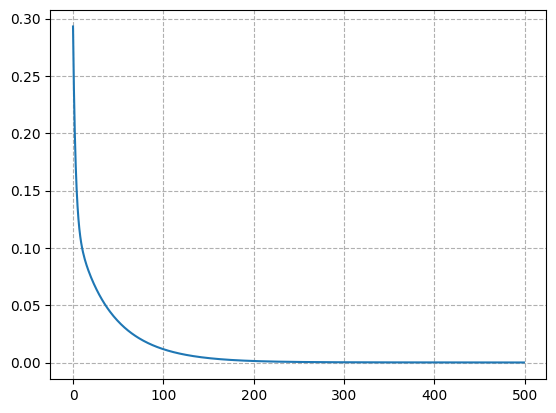

In [19]:
import matplotlib.pyplot as plt

plt.plot(loss_ls)
plt.grid(linestyle='--')
plt.show()

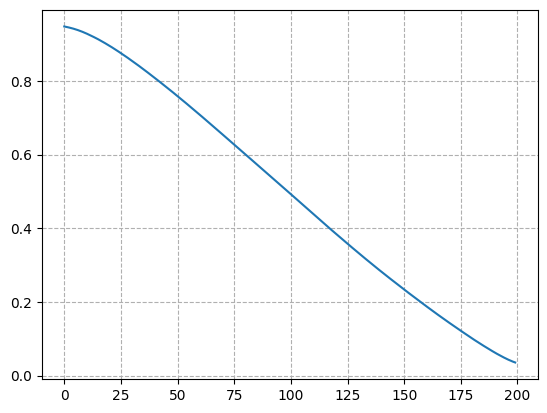

In [20]:
plt.plot(y_pred.cpu().detach().numpy())
plt.grid(linestyle='--')
plt.show()

## Naive regression with positional encoding

In [21]:
num = 200.0
x = torch.arange(num, device=device)
y = torch.arange(num, device=device).flip(0) / num
x, y

(tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
          12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
          24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
          36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
          48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
          60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
          72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
          84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
          96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
         108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
         120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
         132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
         144., 145., 146., 1

In [43]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, b: float = 1.25, l: int = 100) -> None:
        super(PositionalEncoding, self).__init__()
        self.w = b ** torch.arange(int(l / 2), device=device) * torch.pi

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.cat([torch.sin(self.w * x.unsqueeze(-1)), torch.cos(self.w * x.unsqueeze(-1))], dim=-1)
    
encoder = PositionalEncoding()

In [23]:
encoder(x).shape

torch.Size([200, 100])

In [24]:
from torch import nn

hidden = 500

model = nn.Sequential(
    nn.Linear(100, hidden),
    nn.ReLU(),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 1),
).to(device)

In [25]:
import numpy as np
from tqdm.auto import tqdm

loss_ls = []
loss_fn = nn.MSELoss()

for epoch in (pdar := tqdm(range(100 * 5))):
    y_pred = model(encoder(x))
    loss = loss_fn(y.unsqueeze(-1), y_pred)
    loss_ls.append(loss.item())
    pdar.set_description(f'loss {loss.item():.4f} std {y_pred.std().item():.4f}')

    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= 0.1 * param.grad
            param.grad.zero_()

  0%|          | 0/500 [00:00<?, ?it/s]

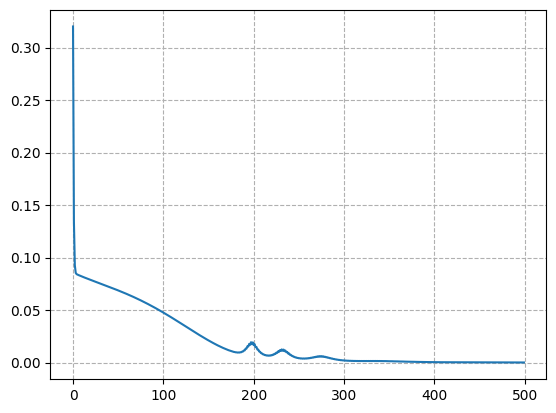

In [26]:
import matplotlib.pyplot as plt

plt.plot(loss_ls)
plt.grid(linestyle='--')
plt.show()

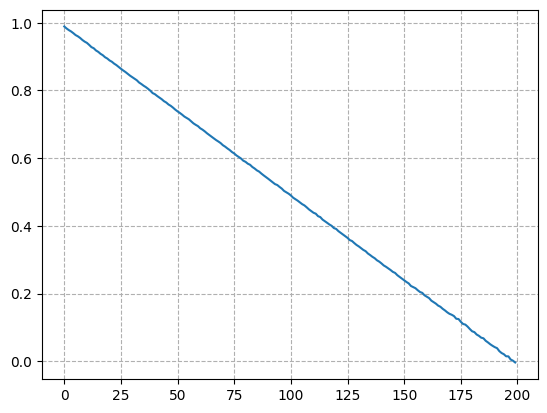

In [27]:
plt.plot(y_pred.cpu().detach().numpy())
plt.grid(linestyle='--')
plt.show()

## Naive `sensor` -> `pressure` regression

In [44]:
num = 198.0
x = torch.arange(num, device=device)
y = pedar_gt / pedar_gt.max()
x, y

(tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
          12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
          24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
          36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
          48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
          60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
          72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
          84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
          96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
         108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
         120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
         132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
         144., 145., 146., 1

In [45]:
y.min(), y.max(), y.std()

(tensor(0.0520, device='mps:0'),
 tensor(1., device='mps:0'),
 tensor(0.1448, device='mps:0'))

In [12]:
from torch import nn

hidden = 2000

pos_emb_l = 100
encoder = PositionalEncoding(l=pos_emb_l)

model = nn.Sequential(
    nn.Linear(pos_emb_l, hidden),
    nn.ReLU(),
    nn.Linear(hidden, hidden * 2),
    nn.ReLU(),
    nn.Linear(hidden * 2, hidden * 4),
    nn.ReLU(),
    nn.Linear(hidden * 4, hidden * 2),
    nn.ReLU(),
    nn.Linear(hidden * 2, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 1),
).to(device)

In [31]:
import numpy as np
from tqdm.auto import tqdm

loss_ls = []
loss_fn = nn.MSELoss()
lr = 0.1

for epoch in (pdar := tqdm(range(500))):
    y_pred = model(encoder(x))
    loss = loss_fn(y.unsqueeze(-1), y_pred)
    loss_ls.append(loss.item())
    pdar.set_description(f'epoch {epoch} loss {loss.item():.4f} std {y_pred.std().item():.4f}')

    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad
            param.grad.zero_()

  0%|          | 0/500 [00:00<?, ?it/s]

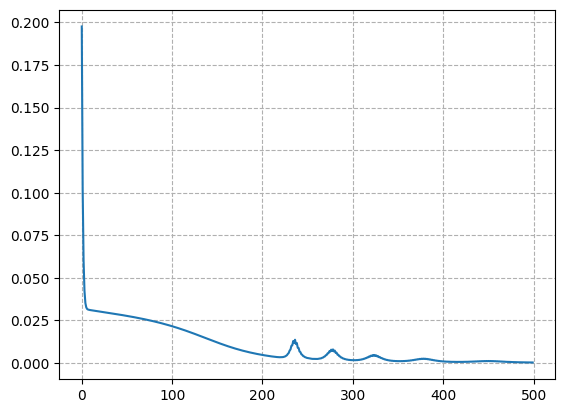

In [32]:
import matplotlib.pyplot as plt

plt.plot(loss_ls)
plt.grid(linestyle='--')
plt.show()

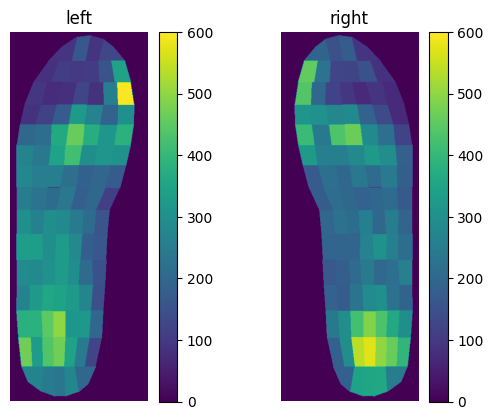

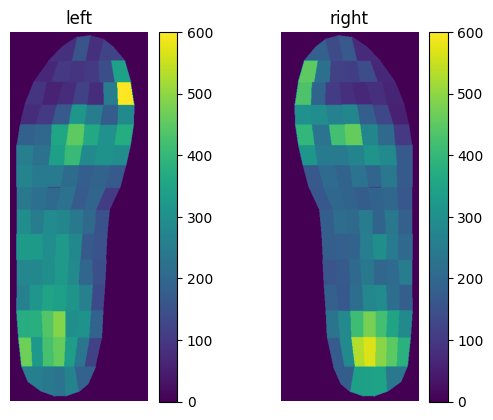

In [33]:
visual.draw_heatmap(y_pred.cpu().detach().numpy() * 600, '../../data/processed/left_foot_mask.png')
visual.draw_heatmap(y.cpu().detach().numpy() * 600, '../../data/processed/left_foot_mask.png')

## `sensor` to `pressure`

In [46]:
num = 198.0
x = torch.arange(num, device=device)
x

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 14

In [47]:
from torch import nn

hidden = 2000

pos_emb_l = 100
encoder = PositionalEncoding(l=pos_emb_l)

model = nn.Sequential(
    nn.Linear(pos_emb_l, hidden),
    nn.ReLU(),
    nn.Linear(hidden, hidden * 2),
    nn.ReLU(),
    nn.Linear(hidden * 2, hidden * 4),
    nn.ReLU(),
    nn.Linear(hidden * 4, hidden * 2),
    nn.ReLU(),
    nn.Linear(hidden * 2, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 1),
).to(device)

In [48]:
import numpy as np
from torch import nn
from tqdm.auto import tqdm

loss_ls = []
loss_fn = nn.MSELoss()
lr = 0.1

for epoch in (pdar := tqdm(range(10))):
    for idx in range(len(dataset)):
        _, y = dataset.__getitem__(idx)
        y /= y.max()
        y_pred = model(encoder(x))
        loss = loss_fn(y.unsqueeze(-1), y_pred)
        loss_ls.append(loss.item())
        pdar.set_description(f'epoch {epoch} loss {loss.item():.4f} std {y_pred.std().item():.4f}')

        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
                param.grad.zero_()

  0%|          | 0/10 [00:00<?, ?it/s]

In [49]:
y.std()

tensor(0.2018, device='mps:0')

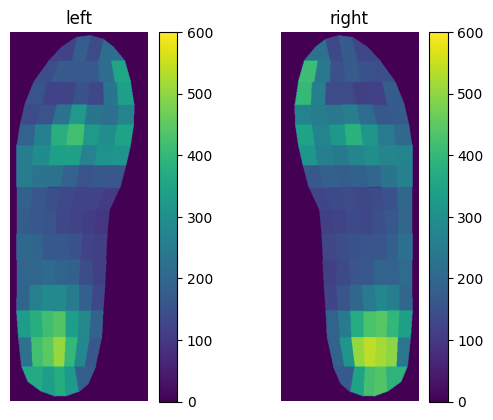

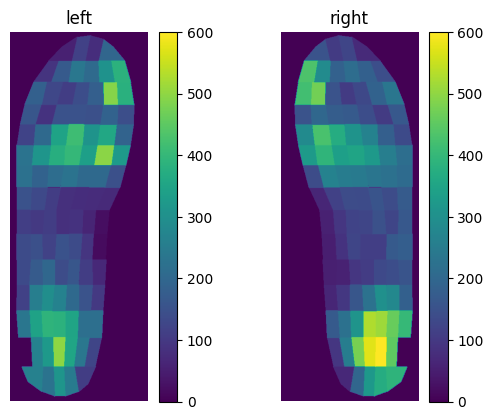

In [52]:
from src.tool import visual

visual.draw_heatmap(y_pred.cpu().detach().numpy() * 600, '../../data/processed/left_foot_mask.png')
visual.draw_heatmap(y.cpu().detach().numpy() * 600, '../../data/processed/left_foot_mask.png')